In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report, confusion_matrix
from skopt import BayesSearchCV
from imblearn.over_sampling import SMOTE  

seed = 42


# Credit card fraud classification
## 1. Read the data 

In [ ]:

# Load the dataset
df = pd.read_csv("creditcard.csv")

## 2. Analysing the data
### Missing values

In [3]:


# Check for missing values
print("Missing values:")
print(df.isnull().sum())


Missing values:
Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64


No missing values. Good!

### Overview of the dataset

In [6]:

# Basic dataset overview
print("Dataset overview:")
print(df.head())


Dataset overview:
   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

        V26   

The features were anonymized so they cannot be interpreted apart from the Time, Amount and Class. Since we are going for a decision tree type of approach there is no need to normalize the data.

## 3. Transform the data
### Split feature X and target y

In [13]:

# Splitting features and target
X = df.drop(columns=["Class"])
y = df["Class"]

y.value_counts()

Class
0    284315
1       492
Name: count, dtype: int64

There is a great imbalance in the dataset which make sense because fraudulent transactions tend to be very infrequent compared to legitimate ones.

### Split between training and testing dataset 

In [ ]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed, stratify=y)

### Fixing the imbalance by oversampling

<Axes: xlabel='Class'>

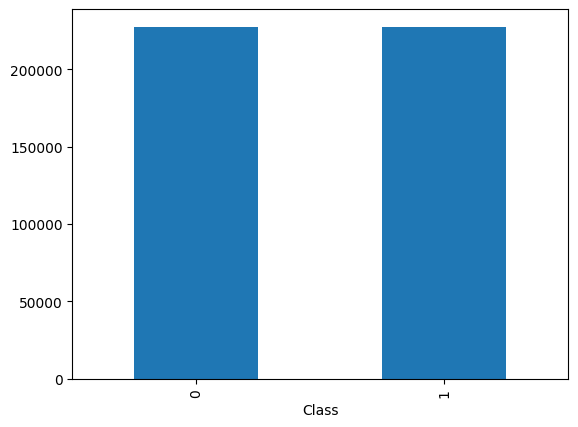

In [ ]:
smote = SMOTE(random_state=seed)

X_train_os, y_train_os = smote.fit_resample(X_train, y_train)
y_train_os.value_counts()

All good we can start now

## 4. Training

### Random forest classifier

In [ ]:

# Define the model
rf = RandomForestClassifier(random_state=seed, n_jobs=-1)


### Optimization of the hyperparameters through Bayesian optimization

In [14]:

# Define hyperparameter search space
param_grid = {
    'n_estimators': (50, 300),
    'max_depth': (5, 50),
    'min_samples_split': (2, 10),
    'max_features': ['sqrt', 'log2', None]
}

# Bayesian optimization
opt = BayesSearchCV(rf, param_grid, n_iter=30, cv=3, scoring='f1', random_state=seed, n_jobs=-1, verbose=2)
opt.fit(X_train_os, y_train_os)


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END max_depth=23, max_features=None, min_samples_split=9, n_estimators=129; total time=10.1min
[CV] END max_depth=23, max_features=None, min_samples_split=9, n_estimators=129; total time=10.1min
[CV] END max_depth=23, max_features=None, min_samples_split=9, n_estimators=129; total time=10.2min
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END max_depth=43, max_features=None, min_samples_split=4, n_estimators=288; total time=22.2min
[CV] END max_depth=43, max_features=None, min_samples_split=4, n_estimators=288; total time=22.2min
[CV] END max_depth=43, max_features=None, min_samples_split=4, n_estimators=288; total time=22.3min
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END max_depth=25, max_features=None, min_samples_split=3, n_estimators=158; total time=12.1min
[CV] END max_depth=25, max_features=None, min_samples_split=3, n_estimators=158; total time=12.1min
[CV] END max_depth=25, 

BayesSearchCV(cv=3,
              estimator=RandomForestClassifier(n_jobs=-1, random_state=42),
              n_iter=30, n_jobs=-1, random_state=42, scoring='f1',
              search_spaces={'max_depth': (5, 50),
                             'max_features': ['sqrt', 'log2', None],
                             'min_samples_split': (2, 10),
                             'n_estimators': (50, 300)},
              verbose=2)

### Best parameters

In [15]:

# Best parameters
print("Best Parameters:")
print(opt.best_params_)

Best Parameters:
OrderedDict([('max_depth', 50), ('max_features', 'log2'), ('min_samples_split', 2), ('n_estimators', 300)])


## 5. Evaluation of the model
### Calculate prediction

In [ ]:

# Evaluate the best model
best_rf = opt.best_estimator_
y_pred = best_rf.predict(X_test)

### Performance metrics

In [17]:

# Performance metrics
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.85      0.85      0.85        98

    accuracy                           1.00     56962
   macro avg       0.92      0.92      0.92     56962
weighted avg       1.00      1.00      1.00     56962



### Confusion matrix 

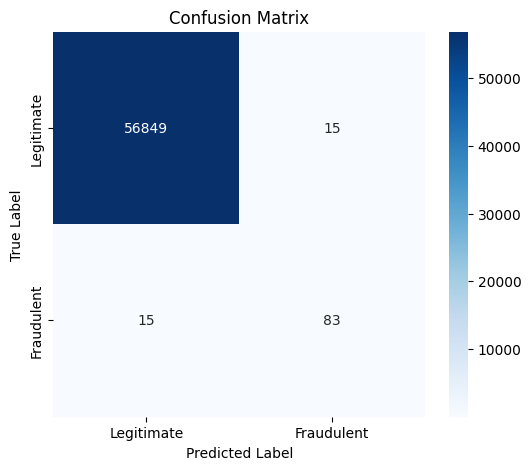

In [22]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Legitimate", "Fraudulent"], yticklabels=["Legitimate", "Fraudulent"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

### Calculate feature importances

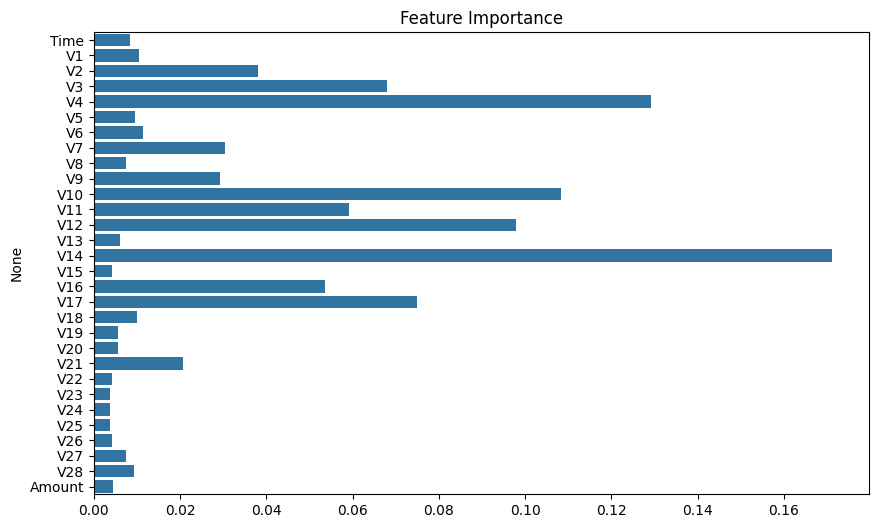

In [18]:

# Plot feature importance
feature_importances = best_rf.feature_importances_
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importances, y=X.columns)
plt.title("Feature Importance")
plt.show()